In [1]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
def solution(x, t, m, C):
    alpha = 1.0 / (m + 1)
    factor = t**(-alpha)
    inner = C - (m - 1) / (2 * m * (m + 1)) * x**2 / (t**(2 * alpha))
    return factor * np.maximum(inner, 0)**(1.0 / (m - 1))

In [3]:
def ic_func(x):
    x_space = x[:, 0:1]                
    return solution(x_space, t0, m, C) # analytic Barenblatt at t0

In [4]:
L = 15.0 
T = 5.0

In [5]:
import deepxde as dde
import numpy as np


def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    um = u**m
    grad_um = dde.grad.jacobian(um, x, i=0, j=0)
    div_flux = dde.grad.jacobian(grad_um, x, i=0, j=0)
    return u_t - div_flux 

t0 = 0.01 * T  
m = 2
C = 1

geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(t0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -L) and not np.isclose(x[1], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1], 0)

# условия нулевые на достаточно далеком иксе
bc_left = dde.DirichletBC(
    geomtime,
    lambda x: 0.0,           
    boundary_left,
    component=0,
)

bc_right = dde.DirichletBC(
    geomtime,
    lambda x: 0.0,         
    boundary_right,
    component=0,
)

def on_initial(x, on_initial):
    return on_initial and np.isclose(x[1], t0)

ic = dde.IC(geomtime, ic_func, on_initial, component=0)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc_left, bc_right, ic],
    num_domain=10000,
    num_boundary=500,
    num_initial=500,
)

net = dde.nn.FNN(
    [2] + [100] * 2 + [1],  
    "tanh",
    "Glorot normal",
)

In [6]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=15000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.653146 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.82e-03, 5.37e-02, 2.04e-02, 3.39e-01]    [9.82e-03, 5.37e-02, 2.04e-02, 3.39e-01]    []  
1000      [1.21e-02, 1.28e-05, 7.37e-06, 4.76e-02]    [1.21e-02, 1.28e-05, 7.37e-06, 4.76e-02]    []  
2000      [7.55e-03, 8.48e-06, 3.04e-05, 1.48e-02]    [7.55e-03, 8.48e-06, 3.04e-05, 1.48e-02]    []  
3000      [5.02e-03, 1.05e-05, 5.04e-06, 6.08e-03]    [5.02e-03, 1.05e-05, 5.04e-06, 6.08e-03]    []  
4000      [3.57e-03, 6.51e-06, 5.80e-06, 3.81e-03]    [3.57e-03, 6.51e-06, 5.80e-06, 3.81e-03]    []  
5000      [2.76e-03, 4.91e-06, 4.54e-06, 3.13e-03]    [2.76e-03, 4.91e-06, 4.54e-06, 3.13e-03]    []  
6000      [2.27e-03, 3.19e-06, 3.52e-06, 2.81e-03]    [2.27e-03, 3.19e-06, 3.52e-06, 2.81e-03]    []  
7000      [1.98e-03, 1.55e-04, 2.09e-04, 2.72e-03]    [1.98e-03, 1.55e-04, 2.09e-04, 2.72e-03]    []  
8

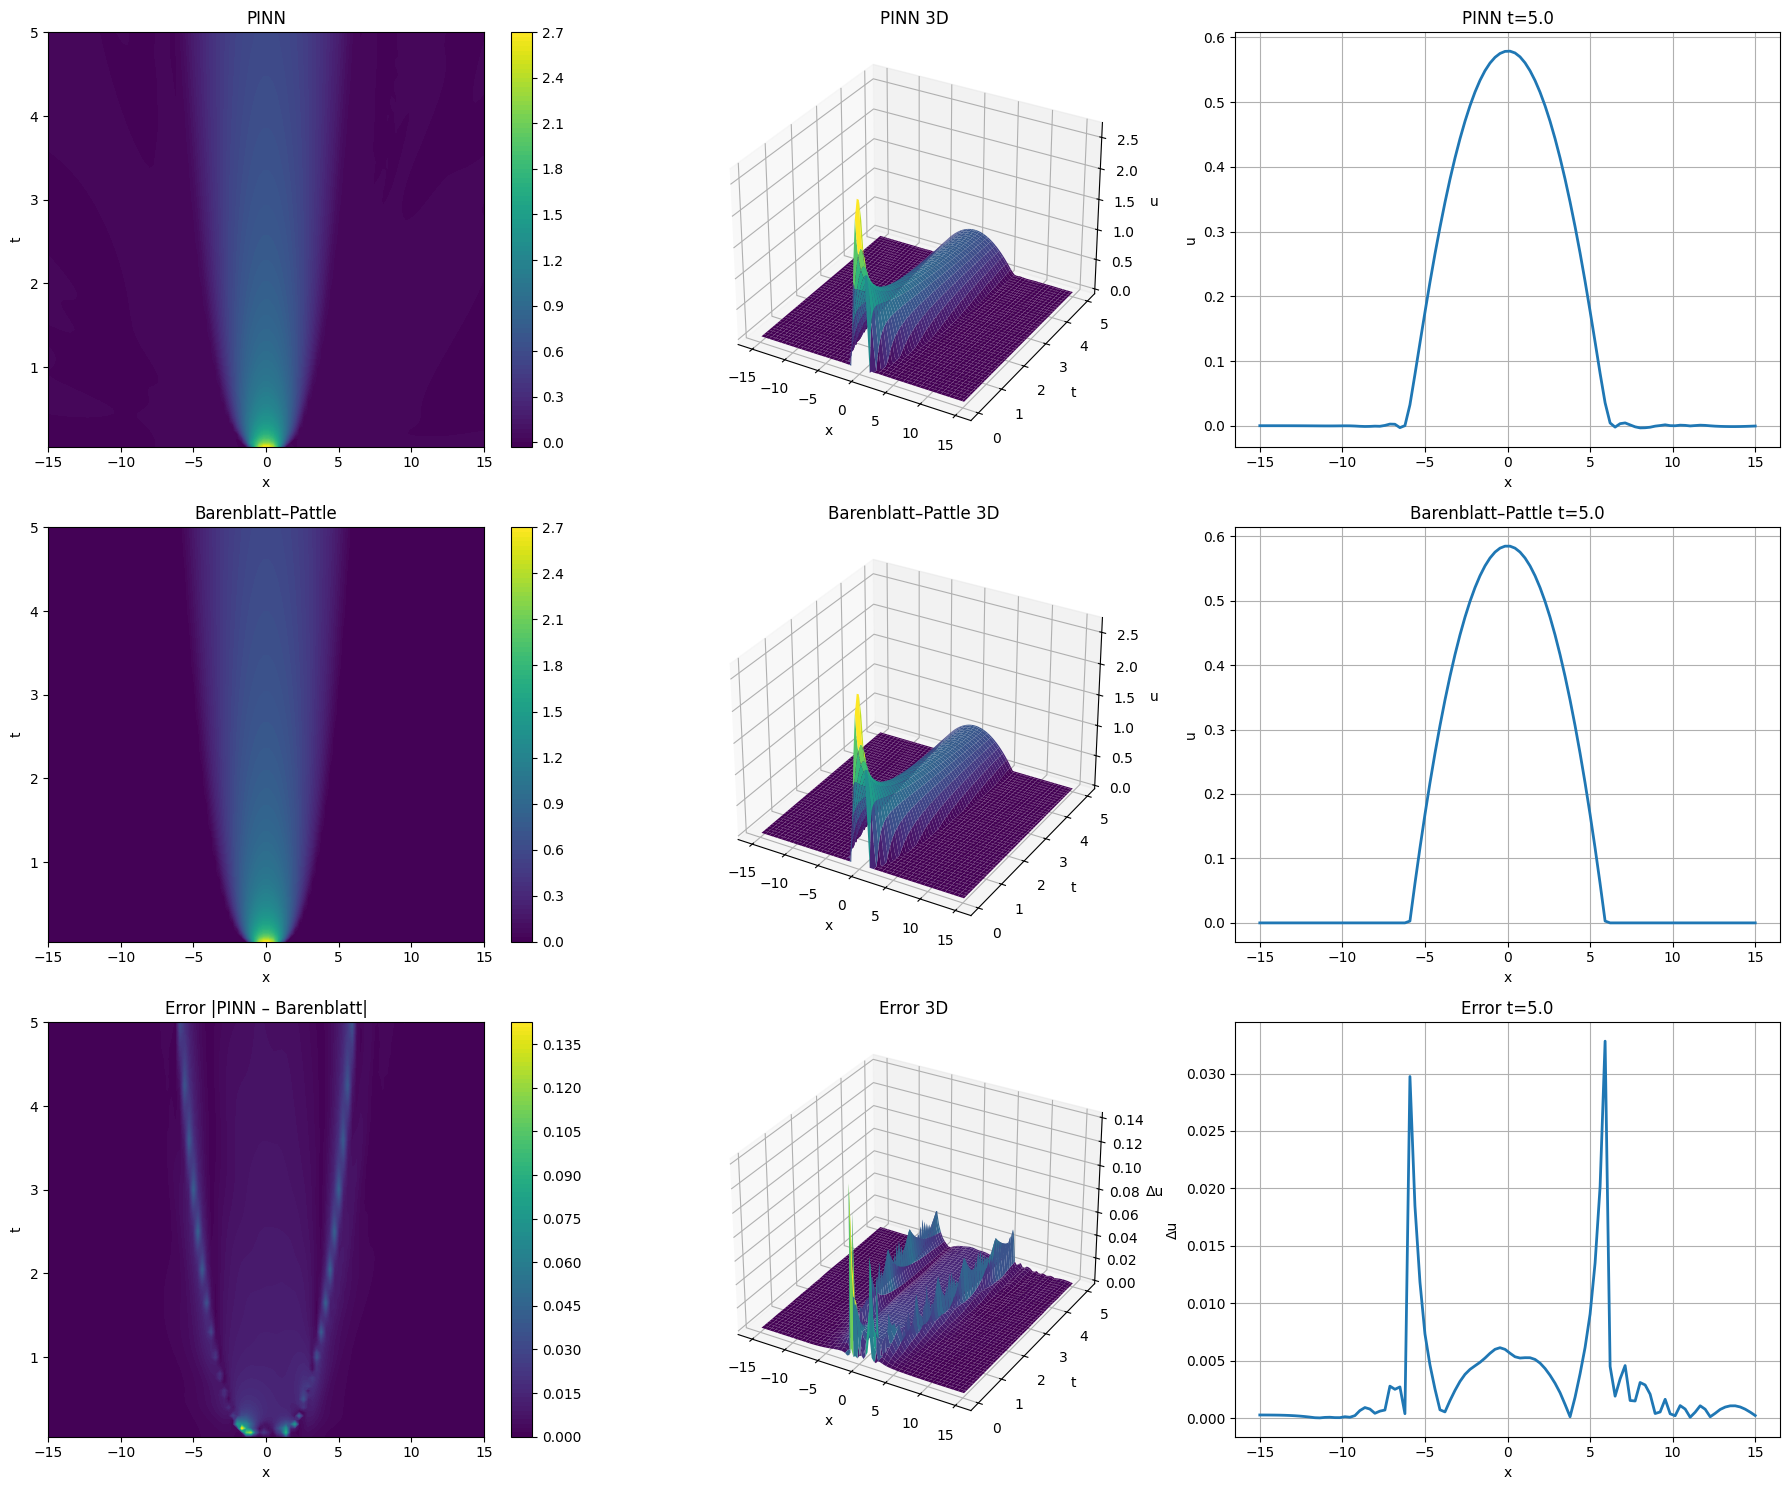

In [15]:
m     = 2.0      
C     = 1.0     
T     = 5
n_x   = 100
n_t   = 100
L = 15.0 

x_vals   = np.linspace(-L, L, n_x)    
t_vals   = np.linspace(t0, T, n_t)      
X, T_grid = np.meshgrid(x_vals, t_vals)
XT       = np.vstack((X.ravel(), T_grid.ravel())).T

U_pinn   = model.predict(XT).reshape(n_t, n_x)

U_bar    = solution(X, T_grid, m, C)

U_diff   = np.abs(U_pinn - U_bar)

fig = plt.figure(figsize=(18, 15))

# Row 1: PINN
ax = fig.add_subplot(3, 3, 1)
cs = ax.contourf(x_vals, t_vals, U_pinn, levels=100)
fig.colorbar(cs, ax=ax)
ax.set_title("PINN")
ax.set_xlabel("x"); ax.set_ylabel("t")

ax = fig.add_subplot(3, 3, 2, projection="3d")
ax.plot_surface(X, T_grid, U_pinn, rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title("PINN 3D")
ax.set_xlabel("x"); ax.set_ylabel("t"); ax.set_zlabel("u")

ax = fig.add_subplot(3, 3, 3)
ax.plot(x_vals, U_pinn[-1], lw=2)
ax.set_title(f"PINN t={T:.1f}")
ax.set_xlabel("x"); ax.set_ylabel("u"); ax.grid(True)

# Row 2: Barenblatt–Pattle
ax = fig.add_subplot(3, 3, 4)
cs = ax.contourf(x_vals, t_vals, U_bar, levels=100)
fig.colorbar(cs, ax=ax)
ax.set_title("Barenblatt–Pattle")
ax.set_xlabel("x"); ax.set_ylabel("t")

ax = fig.add_subplot(3, 3, 5, projection="3d")
ax.plot_surface(X, T_grid, U_bar, rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title("Barenblatt–Pattle 3D")
ax.set_xlabel("x"); ax.set_ylabel("t"); ax.set_zlabel("u")

ax = fig.add_subplot(3, 3, 6)
ax.plot(x_vals, U_bar[-1], lw=2)
ax.set_title(f"Barenblatt–Pattle t={T:.1f}")
ax.set_xlabel("x"); ax.set_ylabel("u"); ax.grid(True)

# Row 3: Error
ax = fig.add_subplot(3, 3, 7)
cs = ax.contourf(x_vals, t_vals, U_diff, levels=100)
fig.colorbar(cs, ax=ax)
ax.set_title("Error |PINN – Barenblatt|")
ax.set_xlabel("x"); ax.set_ylabel("t")

ax = fig.add_subplot(3, 3, 8, projection="3d")
ax.plot_surface(X, T_grid, U_diff, rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title("Error 3D")
ax.set_xlabel("x"); ax.set_ylabel("t"); ax.set_zlabel("Δu")

ax = fig.add_subplot(3, 3, 9)
ax.plot(x_vals, U_diff[-1], lw=2)
ax.set_title(f"Error t={T:.1f}")
ax.set_xlabel("x"); ax.set_ylabel("Δu"); ax.grid(True)

plt.tight_layout()
plt.show()